# Pre-analysis of scATAC-seq data 

In this notebook we will compute the quality checks and dimensionality reduction of scATAC-seq data. It was build based on the <a href=https://satijalab.org/signac/articles/pbmc_vignette.html>Human PBMCs vignette</a> and <a href=https://satijalab.org/signac/articles/mouse_brain_vignette.html>Adult Mouse Brain vignette</a> from Signac package.

As an example, we will take the adult mouse brain scATAC-seq dataset from 10x Genomics:
* <a href=http://cf.10xgenomics.com/samples/cell-atac/1.1.0/atac_v1_adult_brain_fresh_5k/atac_v1_adult_brain_fresh_5k_filtered_peak_bc_matrix.h5>Raw data</a>. - <a href=https://support.10xgenomics.com/single-cell-atac/software/pipelines/latest/output/matrices>Info</a>. 
* <a href=http://cf.10xgenomics.com/samples/cell-atac/1.1.0/atac_v1_adult_brain_fresh_5k/atac_v1_adult_brain_fresh_5k_singlecell.csv>Metadata</a>. - <a href=https://support.10xgenomics.com/single-cell-atac/software/pipelines/latest/output/singlecell>Info</a>. 
* <a href=http://cf.10xgenomics.com/samples/cell-atac/1.1.0/atac_v1_adult_brain_fresh_5k/atac_v1_adult_brain_fresh_5k_fragments.tsv.gz>Fragments file</a>. - <a href=https://support.10xgenomics.com/single-cell-atac/software/pipelines/latest/output/fragments>Info</a>. 
* <a href=http://cf.10xgenomics.com/samples/cell-atac/1.1.0/atac_v1_adult_brain_fresh_5k/atac_v1_adult_brain_fresh_5k_fragments.tsv.gz.tbi>Fragments file index</a>.

The advantage of having a scATAC-seq dataset from 10x Genomics is that we have already a preliminary ATAC analysis and some useful metrics. The peak calling (identifying accessible regions, i.e. open chromatin) is also done. The documentation is in <a href=https://support.10xgenomics.com/single-cell-atac/software/pipelines/latest/algorithms/overview>Cell Ranger ATAC website</a>. <br>
These are some extra steps suggested by Satija lab.

We can also add gene annotations for the mouse genome. To install the genome assembly and gene annotation packages check: <a href=https://satijalab.org/signac/articles/install.html>Signac Installation</a>.

In [1]:
#Algorithms
library(Signac)
library(Seurat)
library(SeuratDisk) #to save Seurat object

#Genome 
library(GenomeInfoDb)
library(EnsDb.Mmusculus.v79)

#To plot
library(ggplot2)
library(patchwork)
library(stringr)
library(repr) #to change the size of plots within the notebook
set.seed(1234)

Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2

Attaching SeuratObject


Attaching package: 'Seurat'


The following object is masked from 'package:Signac':

    FoldChange


Registered S3 method overwritten by 'cli':
  method     from         
  print.boxx spatstat.geom

Registered S3 method overwritten by 'SeuratDisk':
  method            from  
  as.sparse.H5Group Seurat

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: 'BiocGenerics'


The following objects are masked from 'package:parallel':

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from 'package:stats':

    IQR, mad, sd, var, xtabs


The following objects are masked from 'package:base':

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplica

## 0. Load Data

In [2]:
#read ATAC-seq data
counts <- Read10X_h5("./adult_mouse_brain/Inputs/ATAC-seq/atac_v1_adult_brain_fresh_5k_filtered_peak_bc_matrix.h5")

#read metadata
metadata <- read.csv(file = "./adult_mouse_brain/Inputs/ATAC-seq/atac_v1_adult_brain_fresh_5k_singlecell.csv",
                     header = TRUE,
                     row.names = 1)

#create a chromatin assay using the count matrix
brain_assay <- CreateChromatinAssay(counts = counts,
                                    sep = c(":", "-"),
                                    genome = "mm10",
                                    fragments = './adult_mouse_brain/Inputs/ATAC-seq/atac_v1_adult_brain_fresh_5k_fragments.tsv.gz',
                                    min.cells = 1)

#The ChromatinAssay class extends the standard Seurat Assay class and adds several 
#additional slots for data useful for the analysis of single-cell chromatin datasets. 

#create Seurat Object
brain <- CreateSeuratObject(counts = brain_assay,
                            assay = 'ATAC',
                            project = 'ATAC',
                            meta.data = metadata)

# extract gene annotations from EnsDb
annotations <- GetGRangesFromEnsDb(ensdb = EnsDb.Mmusculus.v79)

seqlevelsStyle(annotations) <- 'UCSC'
genome(annotations) <- "mm10"

# add the gene information to the object
Annotation(brain) <- annotations

Warning message in sparseMatrix(i = indices[] + 1, p = indptr[], x = as.numeric(x = counts[]), :
"'giveCsparse' has been deprecated; setting 'repr = "T"' for you"
Computing hash

Warning message in CreateSeuratObject.Assay(counts = brain_assay, assay = "ATAC", :
"Some cells in meta.data not present in provided counts matrix."
Fetching data...
OK

Parsing exons...
OK
Defining introns...
OK
Defining UTRs...
OK
Defining CDS...
OK

aggregating...

Done

Fetching data...
OK

Parsing exons...
OK
Defining introns...
OK
Defining UTRs...
OK
Defining CDS...
OK

aggregating...

Done

Fetching data...
OK

Parsing exons...
OK
Defining introns...
OK
Defining UTRs...
OK
Defining CDS...
OK

aggregating...

Done

Fetching data...
OK

Parsing exons...
OK
Defining introns...
OK
Defining UTRs...
OK
Defining CDS...
OK

aggregating...

Done

Fetching data...
OK

Parsing exons...
OK
Defining introns...
OK
Defining UTRs...
OK
Defining CDS...
OK

aggregating...

Done

Fetching data...
OK

Parsing exons...
OK
D

## 1. Computing QC Metrics

These are the QC Metrics suggested by Satija lab for tha scATAC-seq experiment. The thresholds depend on each particular dataset.
* __Fragment Size Distribution__<br> 
The picture below shows how the fragment size distribution of a successful ATAC-seq experiment should look like. The first peak corresponds to the nuclosome-free fragments, the second to the mononucleosome fragments, and so on.`NucleosomeSignal` will calculate the strength of the nucleosome signal per cell, i.e., the ratio of mononucleosome fragments (147 - 294 bp) to nucleosome-free fragments (< 147 bp). It also estimates the percentile rank of each ratio.<br> 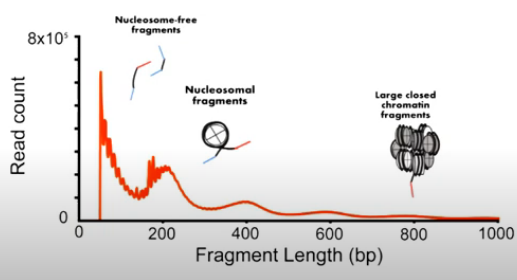<br>

* __Transcriptional start site (TSS) enrichment score__<br>
The <a href=https://www.encodeproject.org/>ENCODE project</a> has defined the TSS enrichment score to evaluate ATAC-seq data. The TSS enrichment score is the ratio between aggregate distribution of reads centered on TSSs and that flanking the corresponding TSSs, and it is calculated according to the definition stated <a href=https://www.encodeproject.org/data-standards/terms/#enrichment>here</a>.<br>
The flanking region is the yellow region on the left of the DNA strand. It contains the promoter and may contain enhancers or other protein binding sites. See: <a href=https://en.wikipedia.org/wiki/5%E2%80%B2_flanking_region> wikipedia link</a>. <br>
Poor ATAC-seq experiments typically will have a low TSS enrichment score. Using Signac, we can compute this metric for each cell with the `TSSEnrichment()` function, and the results are stored in metadata under the column name `TSS.enrichment`. We can inspect the TSS enrichment scores by grouping the cells based on the score and plotting the accessibility signal over all TSS sites. <br> <img src="https://upload.wikimedia.org/wikipedia/commons/5/54/Gene_structure_eukaryote_2_annotated.svg" style="width: 500px;" />

The following metrics can be obtained from the output of CellRanger (which is stored in the object metadata), but can also be calculated for non-10x datasets using Signac:

* __Total number of fragments in peaks__<br>
`peak_region_fragments` is the number of fragments overlapping ATAC-seq peaks (open chromatin regions). Cells with very few reads may need to be excluded due to low sequencing depth. Cells with extremely high levels may represent doublets, nuclei clumps, or other artefacts.

* __Fraction of fragments in peaks__<br>
Is the proportion of fragments overlapping peaks that the cell has (`peak_region_fragments`/`passed_filters`), i.e. number of fragments overlapping peaks divided by the the number of fragments. Cells with low values (i.e. <15-20%) often represent low-quality cells or technical artifacts that should be removed. Note that this value can be sensitive to the set of peaks used.

* __Ratio reads in genomic blacklist regions__<br>
The <a href=https://www.encodeproject.org/>ENCODE project</a> has provided a list of <a href=https://github.com/Boyle-Lab/Blacklist>blacklist regions</a>, representing reads which are often associated with artefactual signal. Cells with a high proportion of reads mapping to these areas (compared to reads mapping to peaks) often represent technical artifacts and should be removed. ENCODE black list regions for human (hg19 and GRCh38), mouse (mm10), Drosophila (dm3), and C. elegans (ce10) are included in the Signac package.

The next filters are suggested in the <a href=https://satijalab.org/seurat/archive/v3.1/pbmc3k_tutorial.html>Seurat User Guide</a>. They intended to be for scRNA-seq data, but make sense for scATAC-seq data as well. They are also part of the <a href=https://cole-trapnell-lab.github.io/cicero-release/docs_m3/#loading-10x-scatac-seq-data>Cicero pipeline for 10X scATAC-seq data</a>. We will get rid of cells with low numbers. <br>
In Signac, they filter the peaks in the next step.

* __Non-zero peaks__<br>
`nFeature_ATAC` is the number of peaks that have non zero counts for each cell. `Matrix::colSums(brain_assay@counts != 0)`.

* __Number of readings for each peak__<br>
`nCount_ATAC` is the total count of readings in all the peaks detected within a cell. `Matrix::colSums(brain_assay@counts)`.

Warning message:
"Removed 1592 rows containing non-finite values (stat_bin)."
Warning message:
"Removed 4 rows containing missing values (geom_bar)."


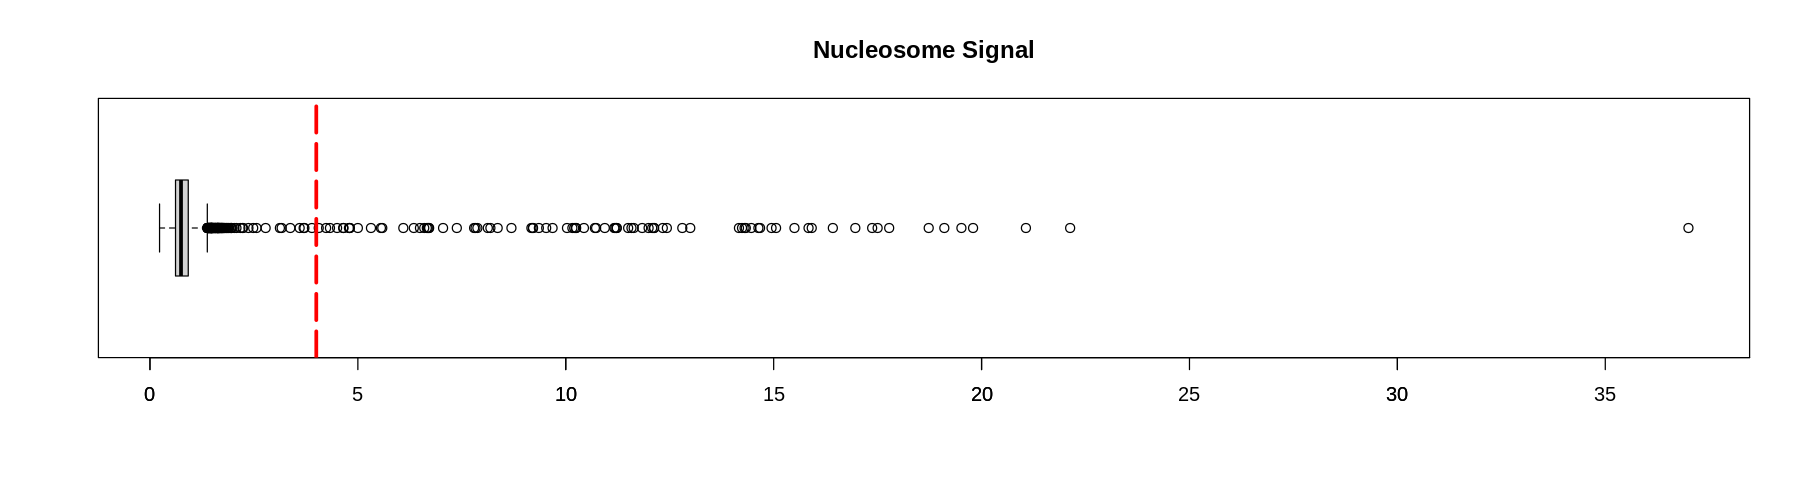

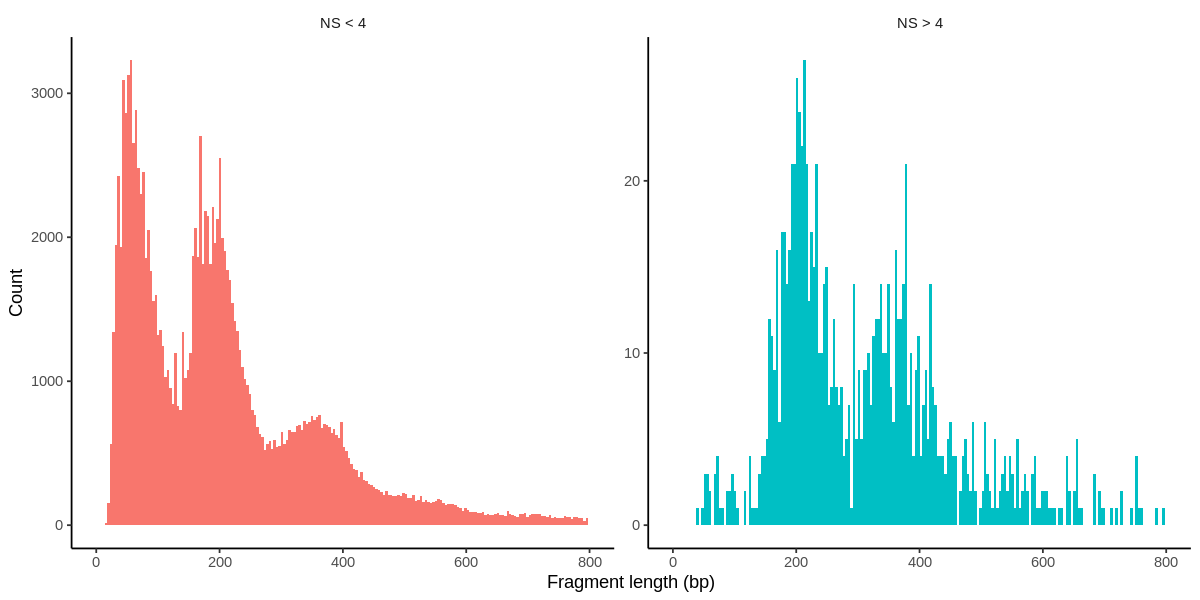

In [3]:
#NucleosomeSignal

brain <- NucleosomeSignal(object = brain)

#Cells which are outliers for the mononucleosomal/ nucleosome-free ratio have different banding patterns. 
#The remaining cells exhibit a pattern that is typical for a successful ATAC-seq experiment.
options(repr.plot.width=15, repr.plot.height=4)
boxplot(brain$nucleosome_signal, main = "Nucleosome Signal", horizontal = TRUE)
axis(1, at=seq(0,40,5)) #change numeration in axis
abline(v=4, col = "Red", lty = 5, lwd = 3) #add line at 4 

options(repr.plot.width=10, repr.plot.height=5)
brain$nucleosome_group <- ifelse(brain$nucleosome_signal > 4, 'NS > 4', 'NS < 4')
FragmentHistogram(object = brain, group.by = 'nucleosome_group', region = 'chr1-1-10000000')

Extracting TSS positions

Finding + strand cut sites

Finding - strand cut sites

Computing mean insertion frequency in flanking regions

Normalizing TSS score



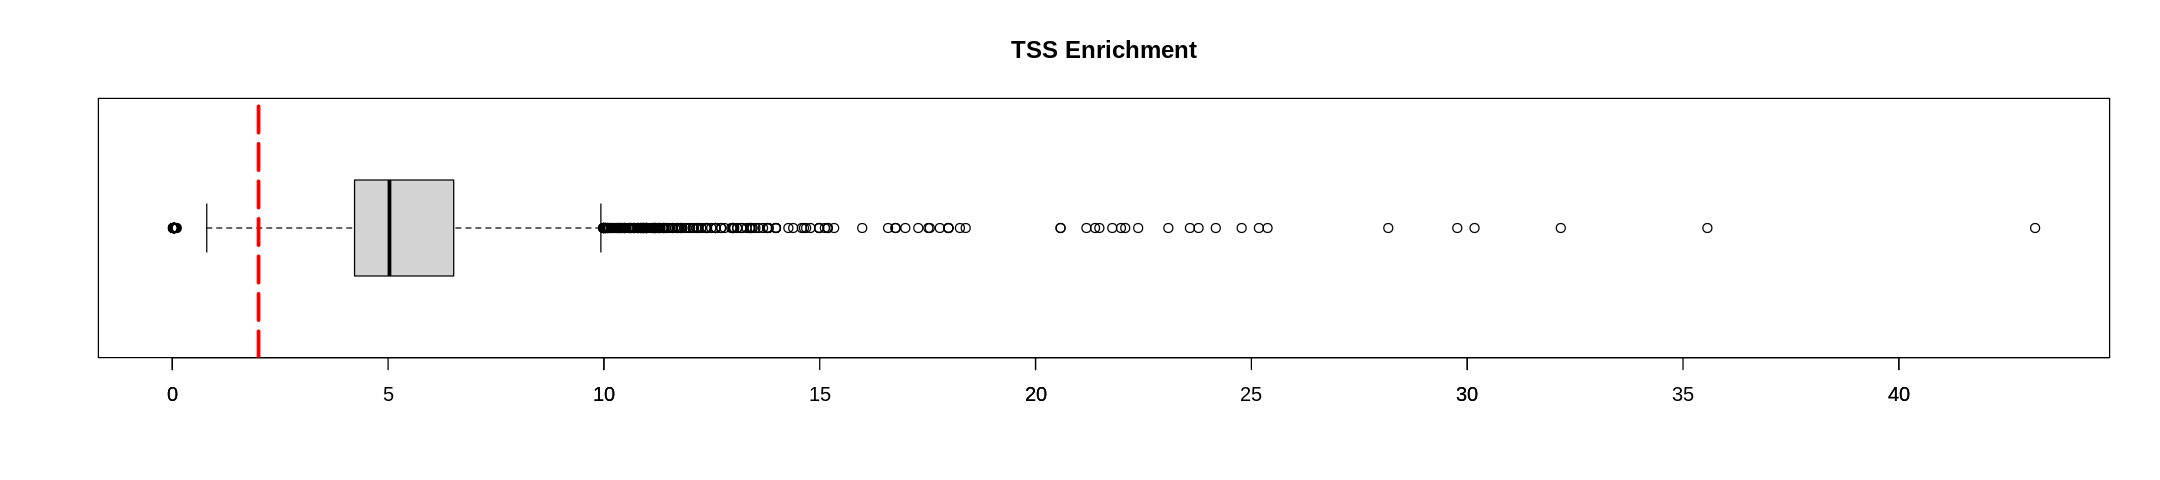

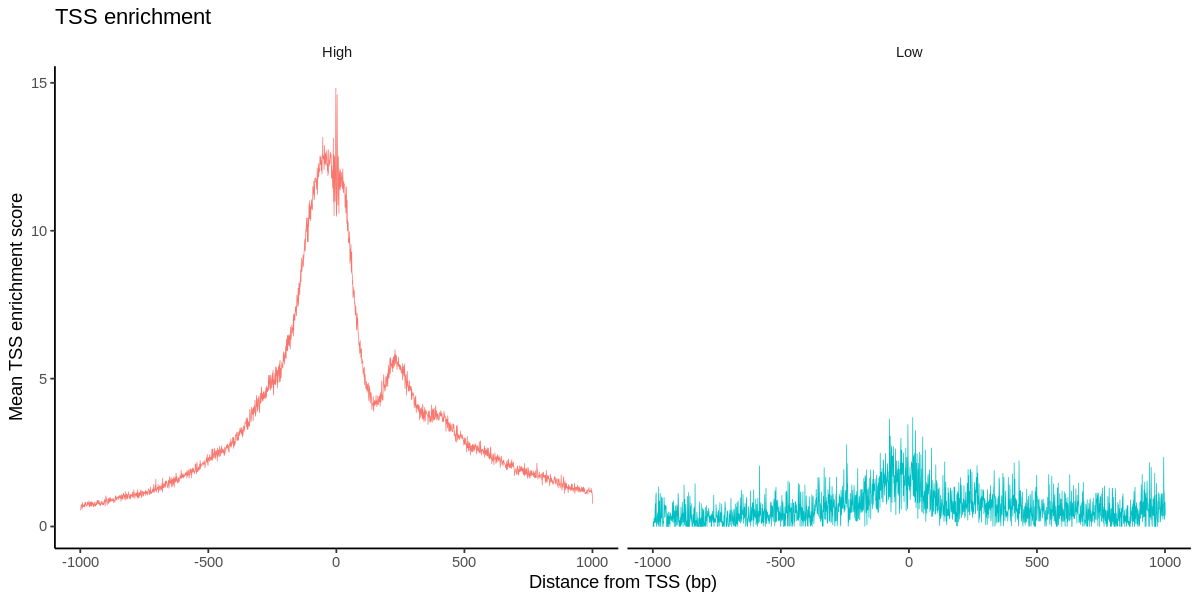

In [4]:
# Computes the transcription start site (TSS) enrichment score for each cell, as defined by ENCODE
brain <- TSSEnrichment(brain, fast = FALSE)

options(repr.plot.width=18, repr.plot.height=4)
boxplot(brain$TSS.enrichment, main = "TSS Enrichment", horizontal = TRUE)
axis(1, at=seq(0,45,5)) #change numeration in axis
abline(v=2, col = "Red", lty = 5, lwd = 3) #add line at 2

options(repr.plot.width=10, repr.plot.height=5)
brain$high.tss <- ifelse(brain$TSS.enrichment > 2, 'High', 'Low')
TSSPlot(brain, group.by = 'high.tss') + NoLegend()

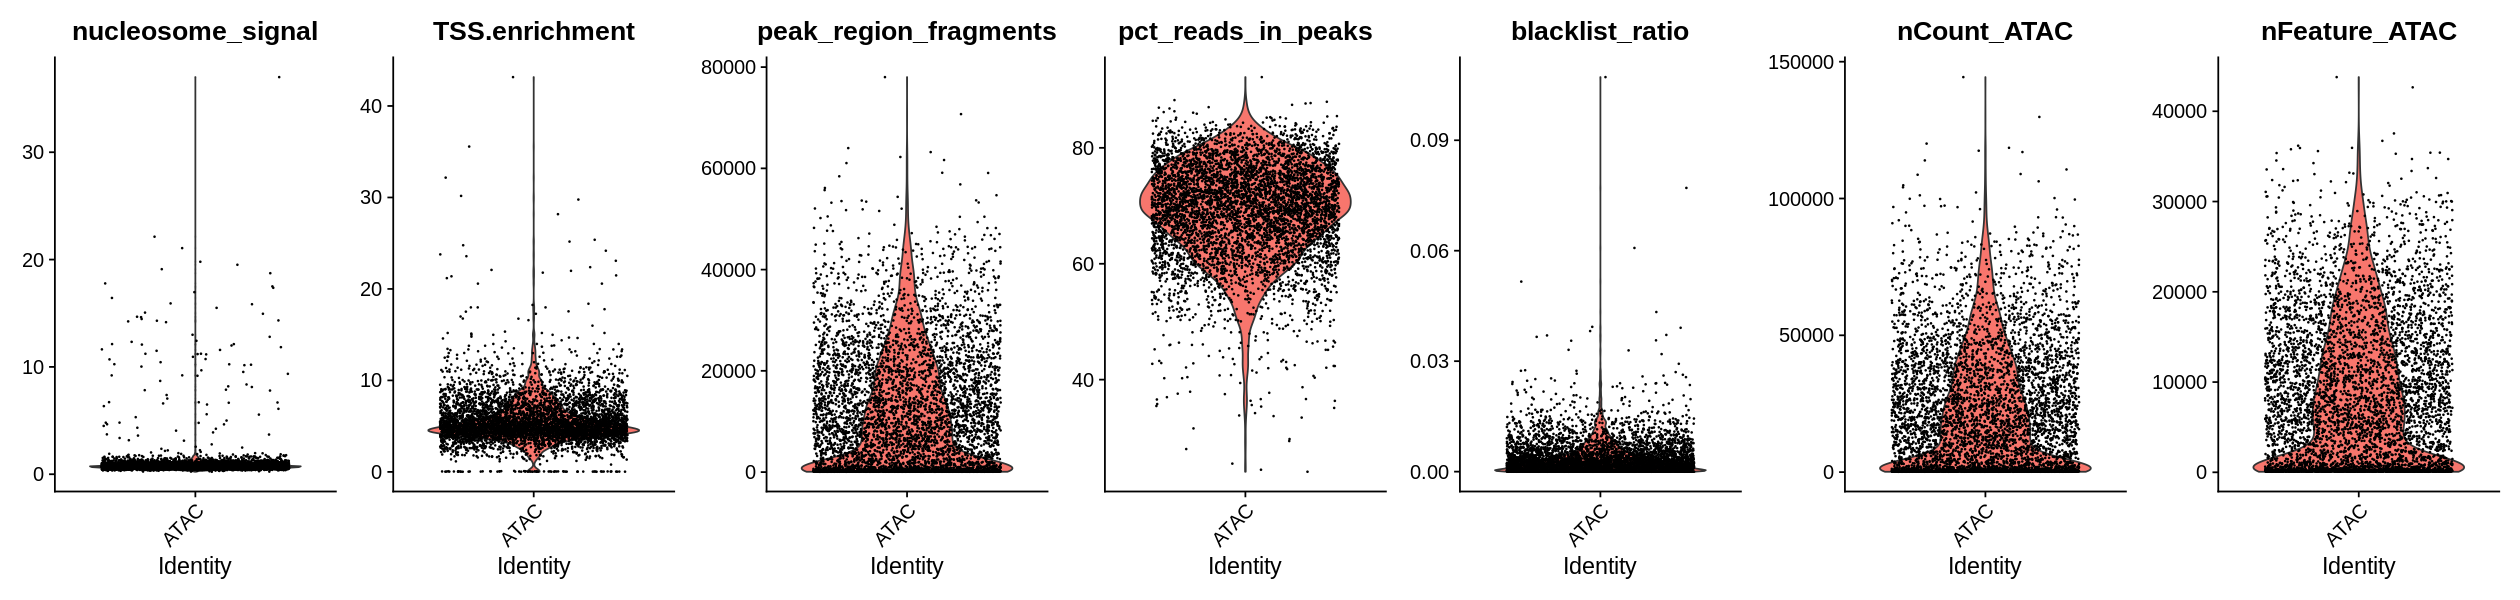

In [5]:
#Plot all our metrics

brain$pct_reads_in_peaks <- brain$peak_region_fragments / brain$passed_filters * 100
brain$blacklist_ratio <- brain$blacklist_region_fragments / brain$peak_region_fragments

options(repr.plot.width=21, repr.plot.height=5)
VlnPlot(object = brain,
        features = c('nucleosome_signal','TSS.enrichment', 'peak_region_fragments', 'pct_reads_in_peaks', 'blacklist_ratio', 'nCount_ATAC','nFeature_ATAC'),
        pt.size = 0.1,
        ncol = 7)

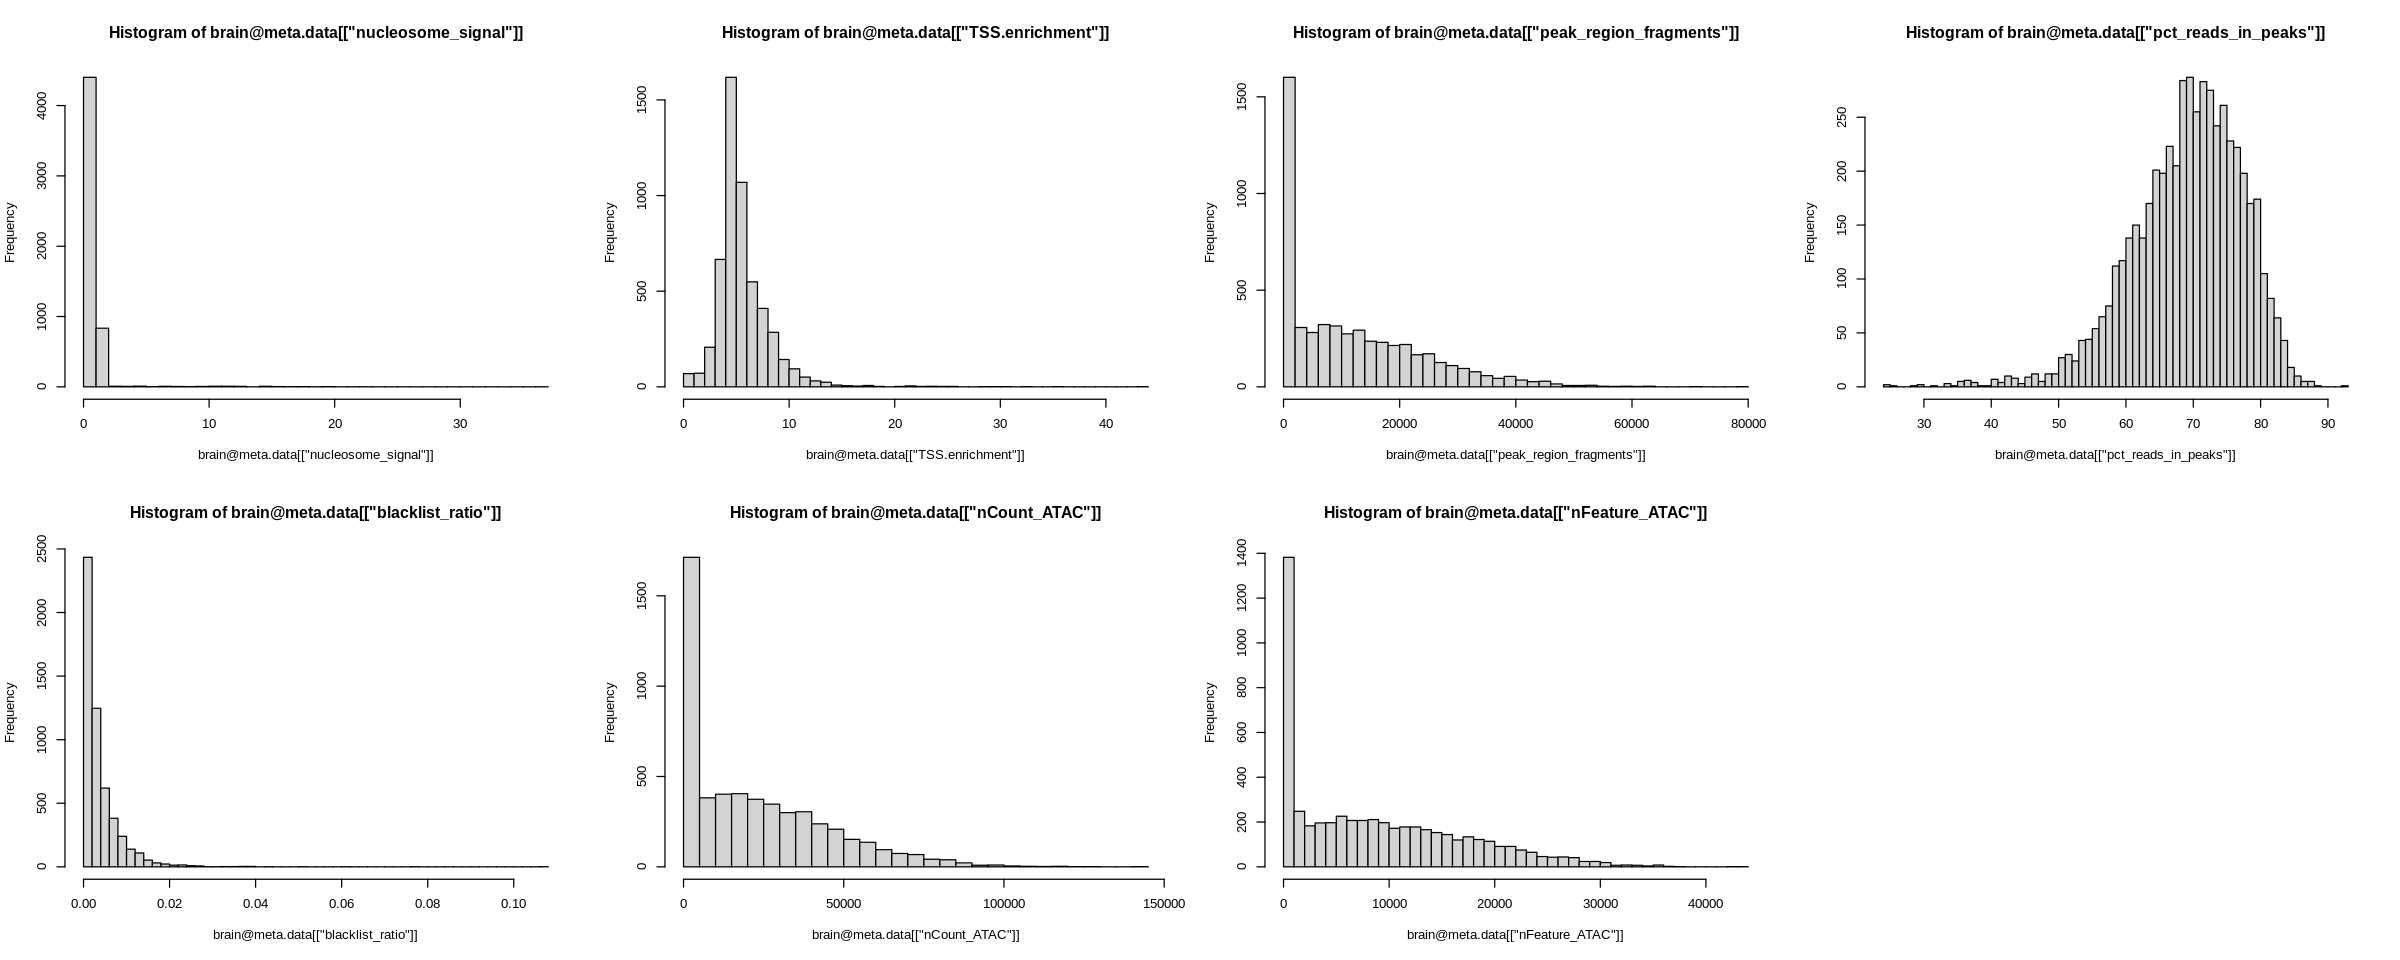

In [6]:
# Visualize peak_count_per_cell
#here, we could choose it in a way that we have 95% of the data or something similar
options(repr.plot.width=20, repr.plot.height=8)
par(mfrow=c(2,4))
hist(brain@meta.data[["nucleosome_signal"]], breaks = 50) 
hist(brain@meta.data[["TSS.enrichment"]], breaks = 50)
hist(brain@meta.data[["peak_region_fragments"]], breaks = 50)
hist(brain@meta.data[["pct_reads_in_peaks"]], breaks = 50)
hist(brain@meta.data[["blacklist_ratio"]], breaks = 50)
hist(brain@meta.data[["nCount_ATAC"]], breaks = 50)
hist(brain@meta.data[["nFeature_ATAC"]], breaks = 50)

Remove cells that are outliers for these QC metrics.

In [7]:
brain <- subset(
  x = brain,
  subset = 
    nucleosome_signal < 4 & 
    TSS.enrichment > 2 &
    peak_region_fragments > 3000 &
    pct_reads_in_peaks > 40 &
    blacklist_ratio < 0.025 #&
#These also can be filtered in the next step, when using Feature Selection:
    #nFeature_ATAC > 3000 &
    #nCount_ATAC > 6000
)
brain

An object of class Seurat 
157203 features across 3512 samples within 1 assay 
Active assay: ATAC (157203 features, 0 variable features)

## 2. Normalization and linear dimensional reduction

The following steps are suggested in Signac website and the descriptions come as well from their vignettes.

* __Normalization:__ Signac performs term frequency-inverse document frequency (TF-IDF) normalization. This is a two-step normalization procedure, that both normalizes across cells to correct for differences in cellular sequencing depth, and across peaks to give higher values to more rare peaks.

* __Feature selection:__ The low dynamic range of scATAC-seq data makes it challenging to perform variable feature selection, as we do for scRNA-seq. Instead, we can choose to use only the top n% of features (peaks) for dimensional reduction, or remove features present in less than n cells with the `FindTopFeatures()` function. Here, we will take all features, though we note that we see very similar results when using only a subset of features (try setting min.cutoff to ‘q75’ to use the top 25% all peaks), with faster runtimes. Features used for dimensional reduction are automatically set as `VariableFeatures()` for the Seurat object by this function. <br> *We can also select features in the step above.*

* __Dimension reduction:__ We next run singular value decomposition (SVD) on the TD-IDF matrix, using the features (peaks) selected above. This returns a reduced dimension representation of the object (for users who are more familiar with scRNA-seq, you can think of this as analogous to the output of PCA).

The combined steps of TF-IDF followed by SVD are known as latent semantic indexing (LSI), and were first introduced for the analysis of scATAC-seq data by <a href=https://science.sciencemag.org/content/367/6473/45.full>Cusanovich et al. 2015</a>.

In [8]:
brain <- RunTFIDF(brain)
brain <- FindTopFeatures(brain, min.cutoff = 'q0')
brain <- RunSVD(object = brain)

Performing TF-IDF normalization

Warning message in RunTFIDF.default(object = GetAssayData(object = object, slot = "counts"), :
"Some features contain 0 total counts"
Running SVD

Scaling cell embeddings



Usually, the first LSI component captures technical variation rather than biological variation. In such case, we should remove it from downstream analysis. To assess the correlation between each LSI component and sequencing depth, we can use the `DepthCor()` function:

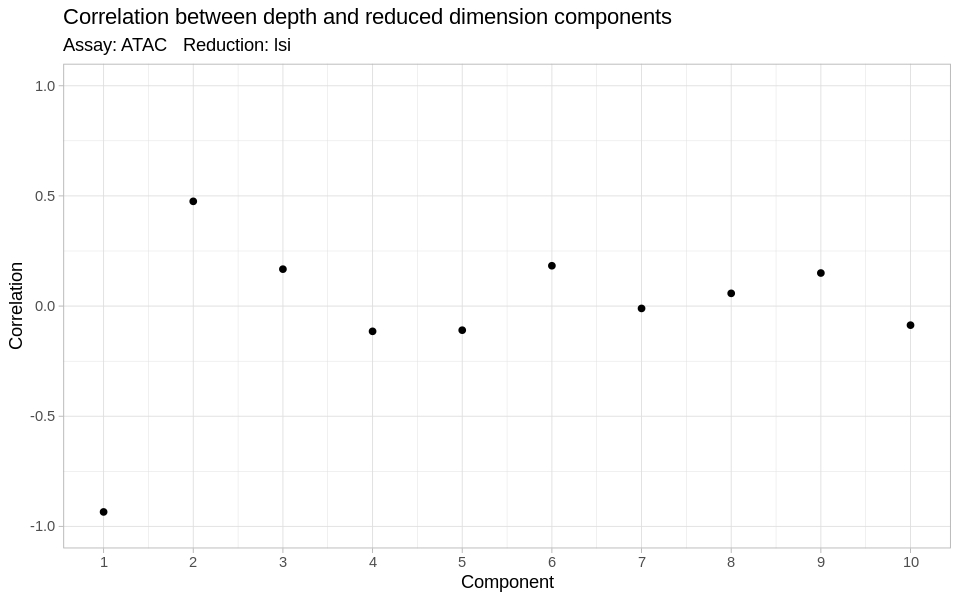

In [9]:
options(repr.plot.width=8, repr.plot.height=5)
DepthCor(brain)

Since the correlation between the first LSI component and the total number of counts for the cell is very strong, we will perform downstream steps without this component.

Now that the cells are embedded in a low-dimensional space, we can use methods commonly applied for the analysis of scRNA-seq data to perform graph-based clustering, and non-linear dimension reduction for visualization.

In [10]:
brain <- RunUMAP(object = brain, reduction = 'lsi', dims = 2:30)
brain <- FindNeighbors(object = brain, reduction = 'lsi', dims = 2:30)
brain <- FindClusters(object = brain, algorithm = 3, resolution = 1.2, verbose = FALSE)

Warning message:
"The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session"
10:36:04 UMAP embedding parameters a = 0.9922 b = 1.112

10:36:04 Read 3512 rows and found 29 numeric columns

10:36:04 Using Annoy for neighbor search, n_neighbors = 30

10:36:04 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

10:36:04 Writing NN index file to temp file /tmp/RtmpicV4uO/filefa03c23f22d87

10:36:04 Searching Annoy index using 1 thread, search_k = 3000

10:36:05 Annoy recall = 100%

10:36:06 Commencing smooth kNN distance calibration using 1 thread

10:36:07 Initializing fr

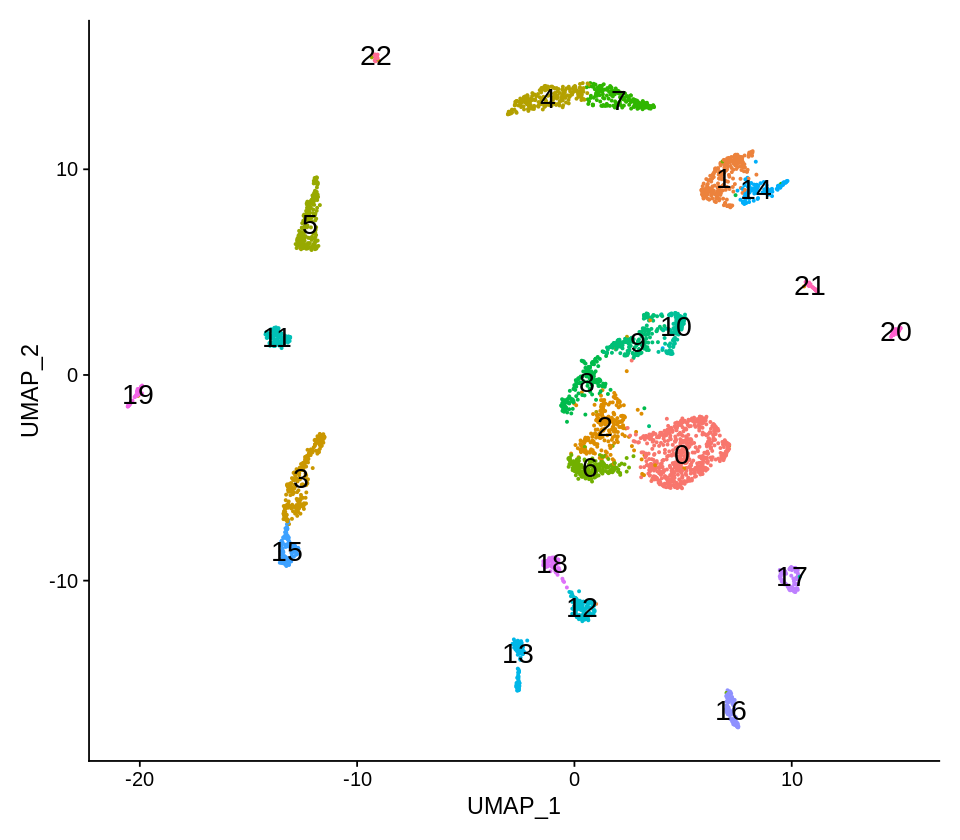

In [11]:
options(repr.plot.width=8, repr.plot.height=7)
DimPlot(object = brain, label = TRUE, label.size = 6) + NoLegend()

# 3. Gene Activity

It is very challenging to interpret and annotate clusters for scATAC-seq data than for scRNA-seq data, since much less is known about the functional roles of noncoding genomic regions than about genes.

However, in Signac they try to quantify the activity of each gene using a simple approach. They sum the fragments intersecting the gene body and promoter region. We can think of it as a measure of chromatin accessibility associated with each gene.

This is done using `GeneActivity()` function, which summarizes the following steps:
1. extract gene coordinates and extend them to include the 2kb upstream region (as promoter accessibility is often correlated with gene expression).
2. count the number of fragments for each cell that map to each of these regions 

In [12]:
# compute gene activities
gene.activities <- GeneActivity(brain)

# add the gene activity matrix to the Seurat object as a new assay
brain[['ACTIVITY']] <- CreateAssayObject(counts = gene.activities)
brain <- NormalizeData(object = brain, assay = 'ACTIVITY', normalization.method = 'LogNormalize',
                       scale.factor = median(brain$nCount_ACTIVITY))

Extracting gene coordinates

Extracting reads overlapping genomic regions

Warning message:
"Non-unique features (rownames) present in the input matrix, making unique"


We can also visualize the activities of canonical marker genes to help interpret the ATAC-seq clusters. They will be much noisier than scRNA-seq measurements, since they come from sparse chromatin data, and because we are relying entirely in the gene body/promoter accessibility and gene expression correspondence. Nevertheless, we can begin to discern populations of cells based on these gene activity profiles.

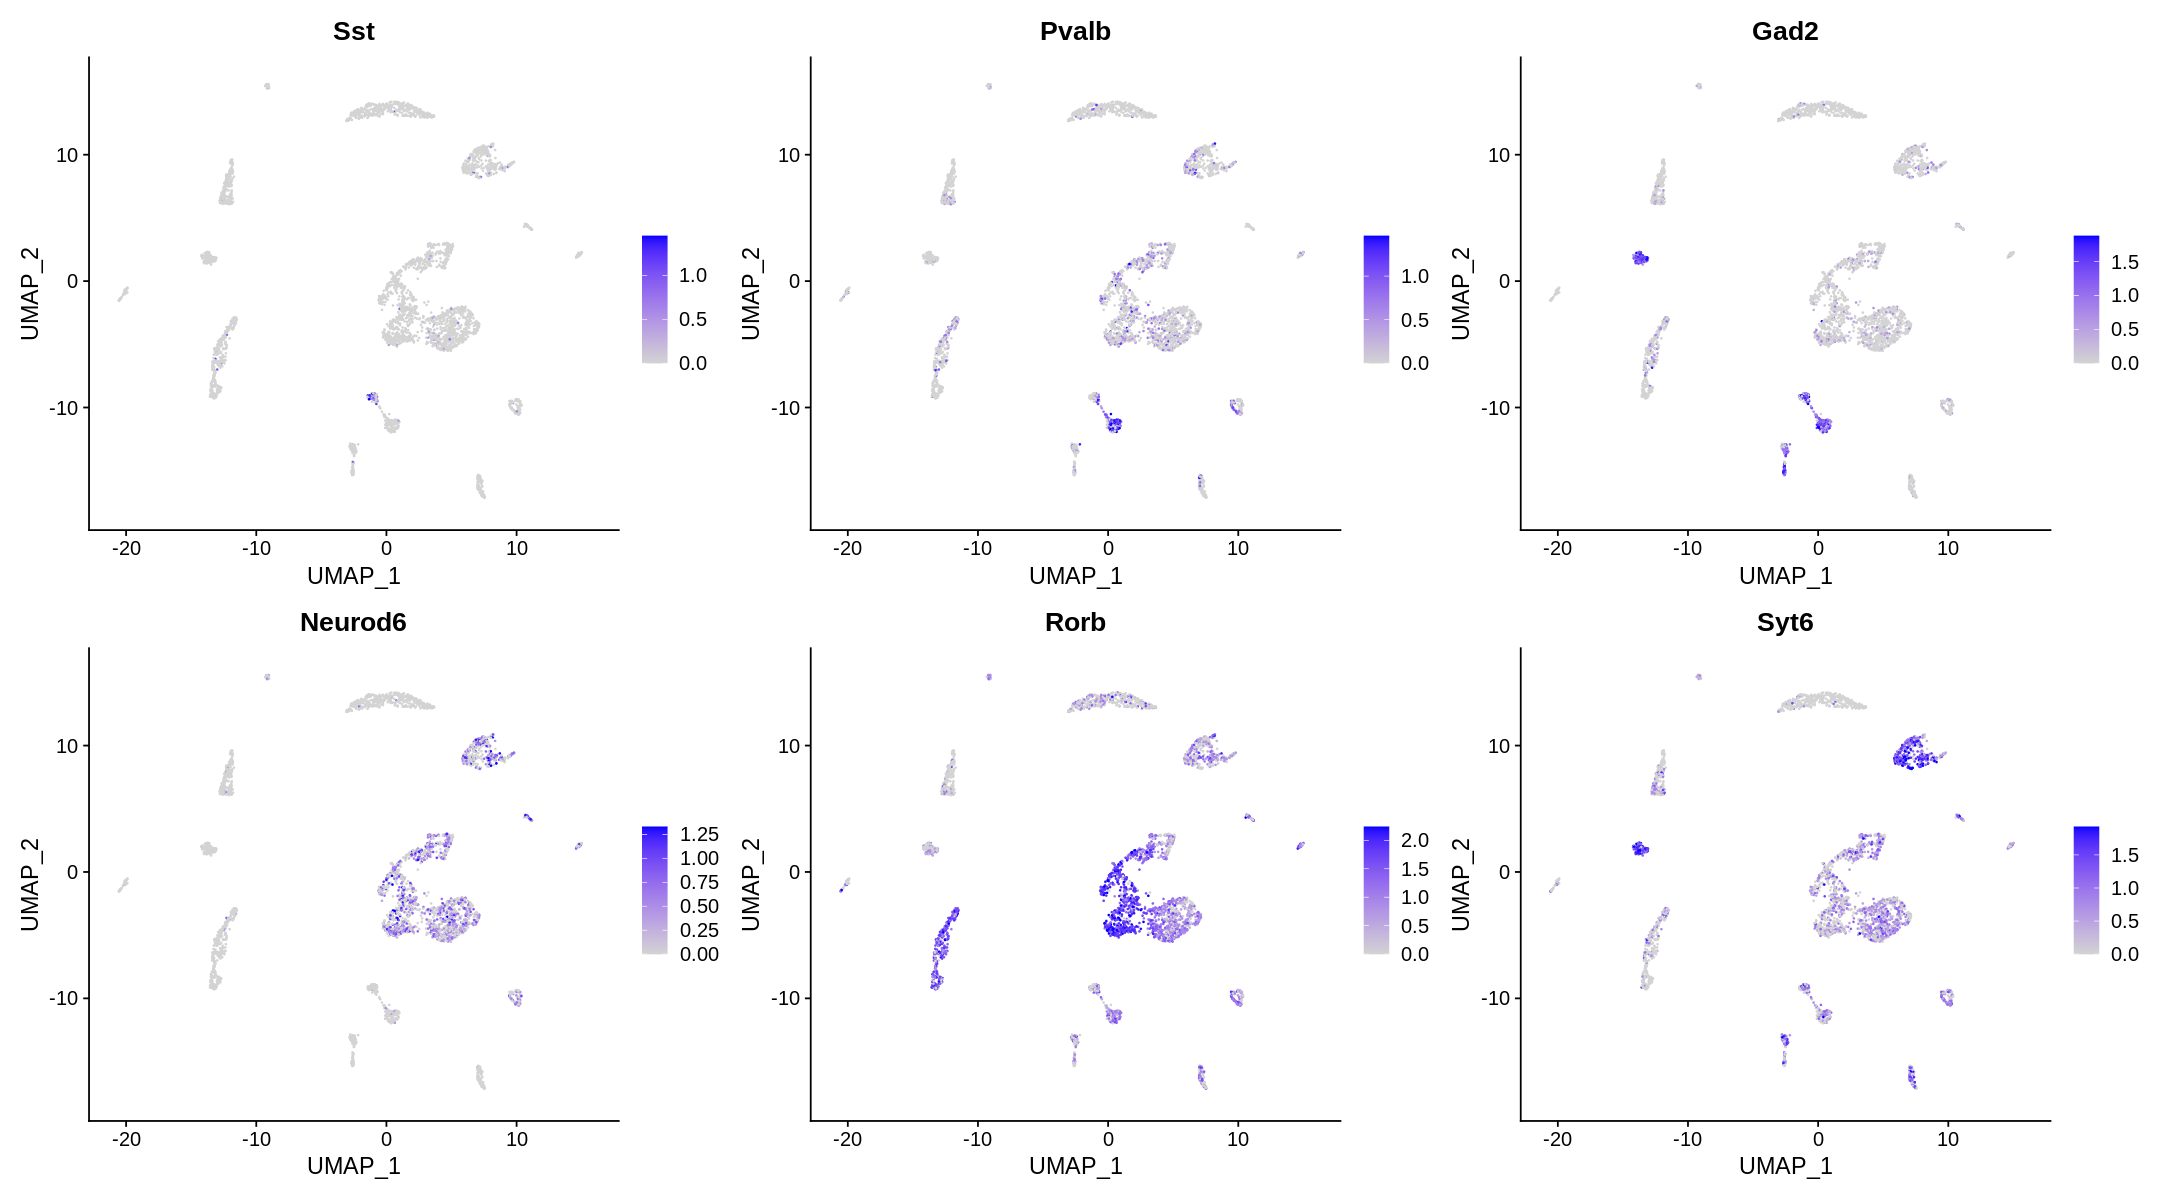

In [13]:
DefaultAssay(brain) <- 'ACTIVITY'
options(repr.plot.width=18, repr.plot.height=10)
FeaturePlot(
  object = brain,
  features = c('Sst','Pvalb',"Gad2","Neurod6","Rorb","Syt6"),
  pt.size = 0.1,
  max.cutoff = 'q95',
  ncol = 3
)

The gene activity scores from scATAC-seq will be also used as input for canonical correlation analysis when integrated this dataset with scRNA-seq info.

## Save output

In [14]:
#save object 
saveRDS(brain, file = "./adult_mouse_brain/Outputs/brain.rds")

Make input for Notebook 1. Coaccessibility (Cicero):

In [15]:
indata <- GetAssayData(object = brain, slot = "counts")

#binarize matrix
indata@x[indata@x > 0] <- 1 

#format cell info
cellinfo <- as.data.frame(colnames(indata))
row.names(cellinfo) <- colnames(indata)
names(cellinfo) <- c("cells")

#format peak info
peakinfo <- as.data.frame(str_split_fixed(rownames(indata), "-", 3))
names(peakinfo) <- c("chr", "bp1", "bp2")
peakinfo$site_name <- paste(peakinfo$chr, peakinfo$bp1, peakinfo$bp2, sep="_")
row.names(peakinfo) <- peakinfo$site_name

#init matrix
colnames(indata) <- NULL
rownames(indata) <- NULL

saveRDS(indata, file = "./adult_mouse_brain/Outputs/indata.rds")
saveRDS(peakinfo, file = "./adult_mouse_brain/Outputs/peakinfo.rds")
saveRDS(cellinfo, file = "./adult_mouse_brain/Outputs/cellinfo.rds")